In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob
from joblib import load, dump
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results


In [2]:
import gc
import tensorflow.keras.backend as K
import tensorflow as tf

def clean(clf): 
    del clf._model
    del clf._performance
    del clf
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras graph

In [3]:
flist = glob('/home/shenwanxiang/Research/AggMapNet_dataset/TCGA-T/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)

In [4]:
dfx = df[df.columns[:-1]]
dfy = df[df.columns[-1:]]
dfx = np.log2(dfx + 1) #apply log2(x + 1)

In [5]:
channel_list = [1, 3, 5,  7, 9, 11] #1,  5,   9,  13
channel_list

[1, 3, 5, 7, 9, 11]

In [6]:
mp = loadmap('/home/shenwanxiang/Research/AggMapNet_dataset/TCGA-T/Agg.c-%s.mp' % 1)

## 10 fold cv performances 

In [ ]:
n_splits = 10 #5-fold 
for c in channel_list: 
    run_all = []
    for repeat_seed in [8]: #repeats random seeds

        outer = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = repeat_seed)
        outer_idx = list(outer.split(range(len(dfy)), dfy))
        mp = mp.refit_c(c)
        Y = pd.get_dummies(dfy['class']).values
        X = mp.batch_transform(dfx.values)

        for i, idx in enumerate(outer_idx):
            
            train_idx, valid_idx = idx
            fold_num = "fold_%s" % str(i+1).zfill(2) 
            
            validY = Y[valid_idx]
            validX = X[valid_idx]

            trainX = X[train_idx]
            trainY = Y[train_idx]

            print("\n input train and test X shape is %s, %s " % (trainX.shape,  validX.shape))
            clf = AggMapNet.MultiClassEstimator(epochs = 100, 
                                                batch_size = 64, 
                                                lr = 1e-3,  
                                                monitor = 'val_metric',
                                                gpuid = 0, verbose = -1, 
                                                metric = 'ACC',)
            clf.fit(trainX, trainY, X_valid = validX, y_valid = validY)

            history = clf.history_model
            history['fold'] = fold_num
            history['c'] = c
            history['repeat_seed'] = repeat_seed
            
            run_all.append(history)
            
            clean(clf)
            
    pd.DataFrame(run_all).to_csv('C=%s.csv' % c)

2021-10-17 22:13:54,946 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-10-17 22:13:58,353 - INFO - [bidd-aggmap] - skipping grid assignment of feature points, fitting to target channel number
2021-10-17 22:13:58,362 - INFO - [bidd-aggmap] - Finished


100%|##########| 10446/10446 [20:15<00:00,  8.60it/s]



 input train and test X shape is (9401, 102, 102, 1), (1045, 102, 102, 1) 
Epoch 1/100
147/147 [==============================] - 22s 30ms/step - loss: 2.9563 - accuracy: 0.1937 - val_loss: 1.1996 - val_accuracy: 0.6507
Epoch 2/100
147/147 [==============================] - 4s 24ms/step - loss: 0.8934 - accuracy: 0.7353 - val_loss: 0.5666 - val_accuracy: 0.8153
Epoch 3/100
147/147 [==============================] - 4s 24ms/step - loss: 0.5210 - accuracy: 0.8386 - val_loss: 0.4472 - val_accuracy: 0.8708
Epoch 4/100
147/147 [==============================] - 4s 24ms/step - loss: 0.3495 - accuracy: 0.8860 - val_loss: 0.3048 - val_accuracy: 0.9091
Epoch 5/100
147/147 [==============================] - 4s 24ms/step - loss: 0.3222 - accuracy: 0.8996 - val_loss: 0.3059 - val_accuracy: 0.9081
Epoch 6/100
147/147 [==============================] - 4s 24ms/step - loss: 0.2794 - accuracy: 0.9118 - val_loss: 0.2942 - val_accuracy: 0.9014
Epoch 7/100
147/147 [==============================] - 4s 2

In [11]:
clf

MultiClassEstimator(batch_norm=False, batch_size=64, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=100, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.001,
                    monitor='val_metric', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=-1)

In [18]:
c = list(mp.colormaps.values())

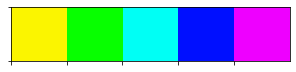

In [21]:
sns.palplot(sns.color_palette('hsv', 5))

In [22]:
sns.color_palette('hsv', 5).as_hex()

['#fcf500', '#08ff00', '#00fff6', '#0010ff', '#ee00ff']